Probing the Limits of Domain Adaptation
---
##### Author: [Sneh Pandya](https://snehjp2.github.io)

In the last tutorial, we saw an instance of distance-based and adversarial domain adaptation (DA) techniques working to improve the generalization of a NN trained on MNIST and evaluated on MNIST-M. We will now move to a more physical dataset of galaxy morphologies, with the differences between source and target domain due to fundamentally different imaging devices. We will be using the Sinkhorn divergence as our distance metric for DA. 

<img src="https://snehjp2.github.io/images/gaussian_meme.png" alt="gaussian meme" width="600"/>


The particular focus here will be playing around with hyperparameters, illustrating the success and failure points of DA and the importance of finding the right sweet-spot for training. We will end with more sophisticated techniques for implementing DA that can automate-away the need for hyperparameter tuning. To that end we will again consider a subset of the full galaxy dataset to simplify the task. We'll start with the same code imports as before:

In [50]:
# torch related imports
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import copy

# miscellaneous
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Callable, Optional
import os
import random

# geomloss provides distance measure that are torch/CUDA compatible. 
# uncomment line below to install it, if you don't have it installed.

# !pip install -q geomloss

from geomloss import SamplesLoss

def set_all_seeds(seed=42):

    os.environ["PYTHONHASHSEED"] = str(seed)  # For Python's hash seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: enforce deterministic algorithms where possible
    torch.use_deterministic_algorithms(True, warn_only=True)
    
set_all_seeds()


Problem Setup
---

Our problem setup follows similarly from Tutorial 1. We will being using the Galaxy Zoo (GZ) Evo dataset for this tutorial. GZ is a citizen science project that labels galaxy images through online participation. GZ Evo combines labeled image datasets across several surveys and iterations of GZ. Within GZ Evo, we use the GZ2 Dataset from the [Sloan Digital Sky Survey](https://www.sdss4.org) (SDSS) [Willett et al., 2013] as the source, and a GZ [Dark Energy Spectroscopic Instrument (DESI) Legacy Imaging Surveys](https://www.legacysurvey.org) dataset that combines observations from the DESI Imaging Surveys (DECals, MzLS, BASS, DES) as the target domain.

- **Neural Network**:  
Let $f_\theta$ denote a neural network classifier with parameters $\theta$, which maps an input image $x \in \mathbb{R}^n$ to predicted class probabilities $\hat{y} = f_\theta(x) \in \mathbb{R}^K$. The network is decomposed into a feature extractor $\phi_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^d$ and a classifier head $g_\theta : \mathbb{R}^d \rightarrow \mathbb{R}^K$, such that $f_\theta(x) = \text{softmax}(g_\theta(\phi_\theta(x)))$.  
We define the **latent representation** $z = \phi_\theta(x)$ as the output of the final hidden layer (before the logits). This representation (also called the *latent vector* or *latent space*) will be used for domain alignment.

- **Source domain dataset**:  
$\mathcal{D}_s = \{(x_s^{(i)}, y_s^{(i)})\}_{i=1}^{N_s}$,  
where $x_s^{(i)} \sim p_s(x)$ are galaxy morphology observations from SDSS, and $y_s^{(i)} \in \{0, 1, \dots, 5\}$ are the corresponding morphology labels. More information on the dataset can be found in Section 3 [here](https://arxiv.org/pdf/2501.14048).

- **Target domain dataset**:  
$\mathcal{D}_t = \{x_t^{(j)}\}_{j=1}^{N_t}$,  
where $x_t^{(j)} \sim p_t(x)$ are unlabeled galaxy morphology observations from the DESI Legacy Imaging Surveys. The included morphologies are the same in both datasets. More information on the dataset can be found in Section 3 [here](https://arxiv.org/pdf/2501.14048).
We assume the label distributions are aligned, i.e., $p_s(y|x) = p_t(y|x)$, but the input distributions differ: $p_s(x) \neq p_t(x)$.  
Our goal is to adapt $f_\theta$ using **only labeled source data** and **unlabeled target data**, so that it performs well on the target domain.

- **Classification loss**:  
On the source domain, we minimize the supervised cross-entropy loss between predicted and true labels:

$$
\mathcal{L}_{\text{CE}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log f_\theta^{(y_s^{(i)})}(x_s^{(i)}),
$$

where $f_\theta^{(k)}(x)$ denotes the predicted probability for class $k$. We proceed similarly to the previous tutorial and consider a subset of the data, so we set $K = 4$ as the number of classes.

---
Let's start by defining our necessary ingredients, starting with the data. We will download the [Galaxy Zoo Evo Dataset](https://huggingface.co/datasets/mwalmsley/gz_evo) from [this link](https://zenodo.org/uploads/14583107) (click the galaxy_dataset.zip). The dataset is 2.35 GB in size; make sure to place it in the `data/` directory for the code below to run correctly.

Recall that images are typically normalized to be in the range [-1,1] for gradient stabilitiy during training. This is done via [z-score normalization](https://en.wikipedia.org/wiki/Standard_score). I've precalculated the means and standard deviations of the datasets for you. Feel free to check this yourself! This is an often not-discussed/overlooked aspect of training NNs, but data normalization is **immensely important**. Lets start by defining our dataset class:


In [51]:
class GZEvo(Dataset):
    """Dataset class for the Galaxy Zoo Evolution dataset.

    Args:
        input_path (str): Path to the input data.
        output_path (Optional[str], optional): Path to the output data. Defaults to None.
        transform (Optional[Callable], optional): Transform to apply to the data. Defaults to None.
    """

    def __init__(
        self,
        input_path: str,
        output_path: Optional[str] = None,
        transform: Optional[Callable] = None,
    ):
        self.input_path = input_path
        self.output_path = output_path
        self.transform = transform

        try:
            self.img = np.load(self.input_path)
            self.label = np.load(self.output_path)
        except Exception as e:
            raise RuntimeError(
                f"Error loading data from {input_path} and {output_path}: {e}"
            )

        self.length = len(self.img)

    def __getitem__(self, idx: int):
        img = self.img[idx]
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.label[idx], dtype=torch.long)
        return img, label

    def __len__(self) -> int:
        return self.length

Like with MNIST-M, we need to be careful about image normalization. I've precalculated the dataset statistics for you again

In [52]:
# Set the size of the subsets for training and testing
train_subset_size = 5000
test_subset_size = 1000

# Precomputed means and standard deviations for normalization
sdss_mean = (0.0439, 0.0388, 0.0289)
sdss_std = (0.0816, 0.0687, 0.0590)
desi_mean = (0.1040, 0.0971, 0.0951)
desi_std = (0.0835, 0.0789, 0.0754)

# Define the target classes we want to keep in the dataset
target_classes = [0, 1, 4, 2]

# Image transformations for the datasets
sdss_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=sdss_mean, std=sdss_std),
                transforms.Resize((28, 28)),
            ]
        )

desi_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=desi_mean, std=desi_std),
                transforms.Resize((28, 28)),
            ]
        )

# Loading the datasets
source_train_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/train/x_train_sdss.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/train/y_train_sdss.npy",
    transform=sdss_transform
)

target_train_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/train/x_train_desi.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/train/y_train_desi.npy",
    transform=desi_transform
)

source_test_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/test/x_test_sdss.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/test/y_test_sdss.npy",
    transform=sdss_transform
)

target_test_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/test/x_test_desi.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/test/y_test_desi.npy",
    transform=desi_transform
)

# Only keep the target classes in the datasets
def filter_indices(dataset, allowed_labels):
    return [i for i, (_, label) in enumerate(dataset) if label in allowed_labels]

filtered_train_indices = filter_indices(source_train_dataset, target_classes)
filtered_test_indices = filter_indices(source_test_dataset, target_classes)

source_train_indices = torch.tensor(filtered_train_indices)[torch.randperm(len(filtered_train_indices))[:train_subset_size]]
source_test_indices = torch.tensor(filtered_test_indices)[torch.randperm(len(filtered_test_indices))[:test_subset_size]]
target_train_indices = filter_indices(target_train_dataset, target_classes)
target_test_indices = filter_indices(target_test_dataset, target_classes)

source_train_dataset = Subset(source_train_dataset, source_train_indices)
source_test_dataset = Subset(source_test_dataset, source_test_indices)
target_train_dataset = Subset(target_train_dataset, target_train_indices)
target_test_dataset = Subset(target_test_dataset, target_test_indices)

# Create DataLoaders for the datasets
source_train_loader = DataLoader(
    source_train_dataset,
    batch_size=64,
    shuffle=True
)
target_train_loader = DataLoader(
    target_train_dataset,
    batch_size=64,
    shuffle=True
)
source_test_loader = DataLoader(
    source_test_dataset,
    batch_size=64,
    shuffle=False
)
target_test_loader = DataLoader(
    target_test_dataset,
    batch_size=64,
    shuffle=False
)

Now that the data is downloaded, lets just sanity check that the images look like what we would expect.

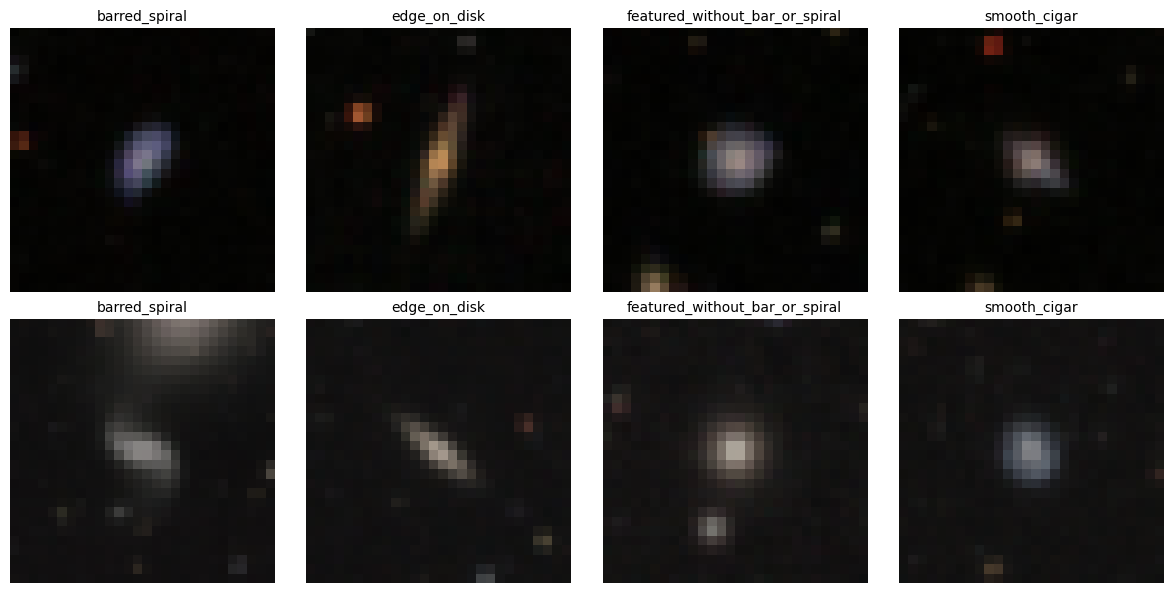

In [53]:
labels_dict = {'barred_spiral': 0, 
               'edge_on_disk': 1, 
               'featured_without_bar_or_spiral': 2, 
               'smooth_cigar': 3, 
               'smooth_round': 4,
               'unbarred_spiral': 5
            }
labels_dict = {v: k for k, v in labels_dict.items()}

def get_examples_by_label(dataset):
    label_to_img = {}
    for img, label in dataset:
        label = int(label)
        if label not in label_to_img:
            label_to_img[label] = img
        if len(label_to_img) == 6:
            break
    return label_to_img

# Undo image normalization
def unnormalize(img, mean, std):
    img = img.clone()
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img

# Collect the examples
sdss_galaxy = get_examples_by_label(source_train_dataset)
desi_galaxy = get_examples_by_label(target_train_dataset)

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for idx, image in enumerate(target_classes):

    image_sdss = unnormalize(sdss_galaxy[image], sdss_mean, sdss_std)
    axes[0, idx].imshow(image_sdss.permute(1, 2, 0).numpy())
    axes[0, idx].set_title(f"{labels_dict[idx]}", fontsize=10)
    axes[0, idx].axis("off")

    image_desi = unnormalize(desi_galaxy[image], desi_mean, desi_std)
    axes[1, idx].imshow(image_desi.permute(1, 2, 0).numpy())
    axes[1, idx].set_title(f"{labels_dict[idx]}", fontsize=10)
    axes[1, idx].axis("off")

axes[0, 0].set_ylabel("SDSS", fontsize=12)
axes[1, 0].set_ylabel("DESI", fontsize=12)
plt.tight_layout()
plt.show()


Pretty pixelated! If you wanna just look at some pretty galaxy pictures, just visualize the images again without resizing. 

Ok, so the images look good, now lets just check that the shapes are the same for training, and that the z-score normalization statistics look ok.

In [54]:
# Get a sample image from each dataset
sdss_image = next(iter(DataLoader(source_test_dataset, batch_size=1)))[0]
desi_image = next(iter(DataLoader(source_train_dataset, batch_size=1)))[0]

# Print the shapes
print("SDSS image shape:", sdss_image.shape) # should be (3, 28, 28)
print("DESI image shape:", desi_image.shape) # should be (3, 28, 28)
print("SDSS image stats:", torch.mean(sdss_image), torch.std(sdss_image)) # should be close to 0 and 1
print("DESI image stats:", torch.mean(desi_image), torch.std(desi_image)) # should be close to 0 and 1

SDSS image shape: torch.Size([1, 3, 28, 28])
DESI image shape: torch.Size([1, 3, 28, 28])
SDSS image stats: tensor(-0.0002, dtype=torch.float64) tensor(0.7648, dtype=torch.float64)
DESI image stats: tensor(0.0263, dtype=torch.float64) tensor(1.1457, dtype=torch.float64)


---
Now let's define our model. We will use the same CNN architecture from the previous tutorial. Since you already wrote the model then, here it is in full.

In [55]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), 

            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.flatten_dim = 128 * 7 * 7

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        z = x.view(x.size(0), -1)
        out = self.classifier(z)
        return out, z

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
CE_only_model = CNN(num_classes=4).to(device)

label_map = {0 : 0, 1 : 1, 4 : 2, 2 : 3}

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(CE_only_model.parameters(), lr=1e-3)
best_model = None
best_loss = float('inf')

# Training loop
num_epochs = 3
for epoch in tqdm(range(num_epochs)):
    CE_only_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in source_train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        
        labels = torch.tensor([label_map[int(l)] for l in labels], device=device)

        # Forward pass
        outputs, _ = CE_only_model(images) ## not using latent z for now
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Model saving
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(CE_only_model.state_dict())

        # Track training stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/len(source_train_loader):.4f}  Accuracy: {100*correct/total:.2f}%")

Using device: cpu


 33%|███▎      | 1/3 [00:20<00:40, 20.23s/it]

Epoch [1/3]  Loss: 0.6802  Accuracy: 75.28%


 67%|██████▋   | 2/3 [00:37<00:18, 18.65s/it]

Epoch [2/3]  Loss: 0.4861  Accuracy: 80.98%


100%|██████████| 3/3 [00:54<00:00, 18.30s/it]

Epoch [3/3]  Loss: 0.4484  Accuracy: 83.46%


In [57]:
def test_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([label_map[int(l)] for l in labels], device=device)

            images = images.float()
            outputs, _ = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Test on source domain (SDSS)
CE_only_model.load_state_dict(best_model)
source_accuracy = test_model(CE_only_model, source_test_loader, device)
print(f"Accuracy on source domain (SDSS): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(CE_only_model, target_test_loader, device)
print(f"Accuracy on target domain (DESI): {target_accuracy:.2f}%")

Accuracy on source domain (SDSS): 81.80%
Accuracy on target domain (DESI): 75.51%


We see that the model has a ~6% discrepancy between the source and target domain. Indeed, despite the galaxy observations coming from fundamentally different imaging instruments, the images dont look *too* different. Can you think about why the two datasets look similar despite coming from SDSS and DESI? Research the photometric filters used in both surveys, and their wavelength coverage. 

*Stretch Question:* Would you expect galaxy observations from JWST and DESI to look similar? What would be different about constructing a model that generalizes between SDSS and JWST observations? Think about imaging modalities, but also think about what kind of galaxies exist at different redshifts. What kind of domain shift would this be? See tips [here](https://ned.ipac.caltech.edu/level5/March04/Conselice/Conselice3.html) and [here](https://www.stsci.edu/jwst/instrumentation).

Now, lets move to domain adaptation and see if we can shrink this performance gap between $\mathcal{D}_s$ and $\mathcal{D}_t$. We will again use `geomloss`, but this time using the Sinkhorn Divergence.

---

The Sinkhorn Divergence
---
![Optimal Transport](https://lchizat.github.io/files/UOTvh.gif)

The optimal transport (OT) distance is distance measure much like MMD. One notable problem with MMD distances is the user-specified choice of kernel function $k$. There are several principled kernel options (e.g., Gaussian, Laplacian, linear, etc.) with the optimal choice of kernel determined through extensive experimentation. A single kernel may not be optimal, either, and a superposition of kernels may be needed for optimal domain alignment. OT distances avoid this by not requiring a kernel function in computing distances, and have gained popularity in recent years due to *entropic regularization* making the calculation of such distances more manageable. The regularized OT is defined as

$$
\text{OT}_\sigma(\mu, \nu) = \min_{\gamma \in U(\mu, \nu)} \left( \sum_{i,j} \gamma_{ij} d(z_i, z_j^*)^p + \sigma H(\gamma) \right),
$$

where $d(z_i, z_j^*)^p$ is the distance between source feature $z_i$ and target feature $z_j^*$. When $p = 1$, this distance becomes the Earth Mover’s Distance [Rubner et al., 1998], and when \( p = 2 \), it becomes the quadratic Wasserstein distance.

The transport plan $\gamma \in U(\mu, \nu)$ is a joint probability distribution between $\mu$ and $\nu$, where the set of admissible transport plans $U(\mu, \nu)$ is defined by the marginal constraints:

$$
\sum_j \gamma_{ij} = \mu_i, \quad \sum_i \gamma_{ij} = \nu_j. \tag{4}
$$

Much of the expense in the regularized OT problem is finding measures that satisfy these constraints. The entropy $H(\gamma) = -\sum_{i,j} \gamma_{ij} \log \gamma_{ij}$ regularizes the transport plan $\gamma$, and $\sigma$ controls the regularization strength (this is sometimes referred to as the "blur" parameter). One limitation of $\text{OT}_\sigma$ is that $\text{OT}_\sigma(\mu, \mu) \ne 0$, implying a non-zero cost even when transporting a distribution to itself, leading to bias in the measure.

To correct this bias, the Sinkhorn divergence $S_\sigma(\mu, \nu)$ is defined as

$$
S_\sigma(\mu, \nu) = \text{OT}_\sigma(\mu, \nu) - \frac{1}{2} \text{OT}_\sigma(\mu, \mu) - \frac{1}{2} \text{OT}_\sigma(\nu, \nu), \tag{5}
$$

a linear combination of $\text{OT}_\sigma$ terms. It can correct for this bias [Feydy et al., 2018]. As $\sigma \to 0$, $S_\sigma(\mu, \nu)$ converges to the (unbiased) optimal transport $\text{OT}_0$, and as $\sigma \to \infty$, it interpolates towards MMD loss [Feydy et al., 2018]. For small values of $\sigma$, an unbiased transport plan that still enjoys the benefits of OT-based distances can be constructed. We're now ready for our full loss function:

$$
\mathcal{L} = \mathcal{L}_{\text{CE}}(y_s, \hat{y}_s) + \lambda \cdot S_\sigma(z, z^*),
$$

where $\lambda$ dictates the strength of the DA loss term.

A few understanding checks before we move forward:
* Double check that the Sinkhorn Divergence is unbiased: $S_\sigma(\mu, \mu) = S_\sigma(\nu, \nu) = 0$. What would happen if you performed DA with a biased measure ($\text{OT}(\mu, \nu)$)?
* There is one hyperparameter here. What is the reason for having $\sigma \to 0$ vs. $\sigma \to \infty$? Read about [Sinkhorn's algorithm](https://lucyliu-ucsb.github.io/posts/Sinkhorn-algorithm/) and think also about computational complexity / speed.
* What would happen when training with $\lambda \to 0$. What about $\lambda = 1$ and $\lambda \gg 1$?

Our focus for these next code blocks will be the $\lambda$ term and one technique to finding the optimal balance between the primary learning objective and DA. Lets start with $\lambda = 0.1$. We will use a fixed value of $\sigma = 10$.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
lambda_DA = 0.1

## TO DO ## 
# Initialize geomloss_fn with Sinkhorn divergence, with the Wasserstein distance cost function and blur ~ 10; tune as needed.
# See https://www.kernel-operations.io/geomloss/api/pytorch-api.html for guidance and syntax.
geomloss_fn = None

best_model = None
best_loss = float('inf')

# Training loop for Domain Adaptation
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()
        
        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Isolate latents
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn(z_s, z_t) 
        total_loss = ce_loss + lambda_DA * DA_loss
        
        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cpu


 17%|█▋        | 1/6 [00:33<02:47, 33.59s/it]

Epoch [1/6], CE Loss: 0.9172, DA Loss: 67.1225 Source Acc: 72.60%, Target Acc: 73.67%


 33%|███▎      | 2/6 [01:08<02:16, 34.13s/it]

Epoch [2/6], CE Loss: 0.8528, DA Loss: 1.7546 Source Acc: 72.98%, Target Acc: 74.31%


 50%|█████     | 3/6 [01:38<01:37, 32.48s/it]

Epoch [3/6], CE Loss: 0.7179, DA Loss: 1.1282 Source Acc: 73.58%, Target Acc: 73.93%


 67%|██████▋   | 4/6 [02:09<01:03, 31.73s/it]

Epoch [4/6], CE Loss: 0.6132, DA Loss: 0.9010 Source Acc: 76.24%, Target Acc: 76.42%


 83%|████████▎ | 5/6 [02:40<00:31, 31.45s/it]

Epoch [5/6], CE Loss: 0.5553, DA Loss: 0.7335 Source Acc: 77.54%, Target Acc: 78.36%


100%|██████████| 6/6 [03:10<00:00, 31.80s/it]

Epoch [6/6], CE Loss: 0.5095, DA Loss: 0.6927 Source Acc: 80.00%, Target Acc: 79.63%


In [59]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (SDSS): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (DESI): {target_accuracy:.2f}%")

Accuracy on source domain (SDSS): 80.10%
Accuracy on target domain (DESI): 79.70%


Ok, so some improvement in the target domain here. But also, notice that the source domain performance dropped! In this case, the DA term is probably slightly overweighed. Just to send the point home, let's then test with a much larger $\lambda$ value ($\lambda \gg 1$).

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
lambda_DA = 1000
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10)
best_model = None
best_loss = float('inf')

# Training loop for Domain Adaptation
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()
        
        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Split latents
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn(z_s, z_t) 
        total_loss = ce_loss + lambda_DA * DA_loss
        
        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cpu


 17%|█▋        | 1/6 [00:35<02:55, 35.19s/it]

Epoch [1/6], CE Loss: 0.9104, DA Loss: 53.7946 Source Acc: 72.14%, Target Acc: 73.20%


 33%|███▎      | 2/6 [01:10<02:21, 35.36s/it]

Epoch [2/6], CE Loss: 0.8809, DA Loss: 1.6699 Source Acc: 72.96%, Target Acc: 74.53%


 50%|█████     | 3/6 [01:49<01:50, 36.77s/it]

Epoch [3/6], CE Loss: 0.8671, DA Loss: 0.7259 Source Acc: 73.00%, Target Acc: 73.66%


 67%|██████▋   | 4/6 [02:24<01:12, 36.03s/it]

Epoch [4/6], CE Loss: 0.8474, DA Loss: 0.5262 Source Acc: 73.24%, Target Acc: 74.03%


 83%|████████▎ | 5/6 [02:57<00:35, 35.29s/it]

Epoch [5/6], CE Loss: 0.8530, DA Loss: 0.4166 Source Acc: 73.08%, Target Acc: 74.78%


100%|██████████| 6/6 [03:35<00:00, 35.93s/it]

Epoch [6/6], CE Loss: 0.8488, DA Loss: 0.3064 Source Acc: 73.20%, Target Acc: 73.16%


In [61]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (SDSS): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (DESI): {target_accuracy:.2f}%")

Accuracy on source domain (SDSS): 75.00%
Accuracy on target domain (DESI): 75.79%


The source domain performance dropped significantly, and the target domain performance is also low. Keep in mind that we would not expect a model trained with DA to outperform the source domain. So while we must focus on domain alignment, it shouldn't come at the expense of the primarily learning objective, whether it be classification or regression.

A reasonable guess would then be that $\lambda$ should be less than 1, but it is hard to guess a priori whether it should be $\mathcal{O}(0.1)$, $\mathcal{O}(0.01)$, etc. To be sure, we'd have to sample $\lambda \sim \text{LogUniform}$ and then refine from there, which can be difficult. Even then, that would only apply for this dataset, and not MNIST in Tutorial 1, or any other dataset. 

So how can we be certain we're doing things optimally? What one would usually think to do in this case is some sort of search, trying out different values of $\lambda$ within an appropriate range and seeing what works best. But even then, the results could be sensitive to the choice of seed, so you should marginalize over multiple realizations and make it a grid search. But also, we haven't even thought about what to do with $\sigma$, which is important as well, so maybe a cube search...?

I think you see where this is going. There's a lot of things that are important here. Here, I'll talk about a *trainable* way to avoid the $\lambda$ search, using an idea from Bayesian inference. See [this paper](https://arxiv.org/abs/1705.07115).

The overall idea is two introduce trainable coefficients for the two loss terms. Let us introduce two trainable scalar parameters $\eta_1$ and $\eta_2$, and define the following loss function:

$$
\mathcal{L} = \frac{1}{2 \eta_1^2} \mathcal{L}_\text{CE} + \frac{1}{2 \eta_2^2} \mathcal{L}_\text{DA} + \log(|\eta_1 \eta_2|) 
$$

These values can then be optimized jointly with the model parameters, avoiding the need for a user-specified weighting for the loss terms.

Let's think about this loss function before proceeding: 

* What happens to each loss term as its corresponding $\eta_i \to 0$.
* What does the third term $\log(|\eta_1 \eta_2|)$ do?
* We saw that strongly preffering $\mathcal{L}_\text{DA}$ over $\mathcal{L}_\text{CE}$ will result in bad performance, and that we probably want $\eta_2^{-2} < 2$. This trainable prescription does not know a priori that doing so is bad. Is there any way to enforce this? *Hint*: Think about what range the parameters should be in, initializing them properly and governing their time evolution.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10)
best_model = None
best_loss = float('inf')

## TO DO ##
# Initialize trainable coefficients eta_1 and eta_2 using nn.Parameter. 
# I recommend starting with eta_1 = 0.1 and eta_2 = 1.0, both requiring gradients. Make sure you understand why they are initialized differently.
eta_1 = None
eta_2 = None

## TO DO ##
# The optimizer naively will only optimize the model parameters. Add the trainable coefficients eta_1 and eta_2 to the optimizer using `add_param_group`
...

# Training loop
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)
        
        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Split latents and outputs
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn(z_s, z_t) 
        ## TO DO ##
        # Compute the total loss using the trainable coefficients eta_1 and eta_2 and the function described above.
        total_loss = None
        
        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(DA_model.parameters(), max_norm=10.0)
        
        ## TO DO ##
        # Clamp eta_1 and eta_2 using x.data.clamp for x \in {eta_1, eta_2} as discussed above. I recommend letting eta_1 be at least 1e-3 and eta_2 be at least 0.25 * eta_1.
        ...
        
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%", "eta_1:", eta_1.item(), "eta_2:", eta_2.item())

Using device: cpu


 17%|█▋        | 1/6 [00:35<02:57, 35.55s/it]

Epoch [1/6], CE Loss: 0.8211, DA Loss: 53.8375 Source Acc: 72.72%, Target Acc: 74.25% eta_1: 0.15483352541923523 eta_2: 1.0123703479766846


 33%|███▎      | 2/6 [01:11<02:23, 35.85s/it]

Epoch [2/6], CE Loss: 0.6194, DA Loss: 1.8429 Source Acc: 76.04%, Target Acc: 78.26% eta_1: 0.18175508081912994 eta_2: 1.012046217918396


 50%|█████     | 3/6 [01:44<01:44, 34.73s/it]

Epoch [3/6], CE Loss: 0.5457, DA Loss: 1.0786 Source Acc: 79.74%, Target Acc: 81.63% eta_1: 0.20137275755405426 eta_2: 1.0113070011138916


 67%|██████▋   | 4/6 [02:17<01:07, 33.76s/it]

Epoch [4/6], CE Loss: 0.5062, DA Loss: 0.7053 Source Acc: 81.44%, Target Acc: 82.28% eta_1: 0.21748045086860657 eta_2: 1.0102862119674683


 83%|████████▎ | 5/6 [02:50<00:33, 33.47s/it]

Epoch [5/6], CE Loss: 0.4727, DA Loss: 0.4756 Source Acc: 83.42%, Target Acc: 82.61% eta_1: 0.23108986020088196 eta_2: 1.009029507637024


100%|██████████| 6/6 [03:26<00:00, 34.36s/it]

Epoch [6/6], CE Loss: 0.4436, DA Loss: 0.4301 Source Acc: 83.48%, Target Acc: 82.77% eta_1: 0.24316373467445374 eta_2: 1.0076370239257812


In [63]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (SDSS): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (DESI): {target_accuracy:.2f}%")

Accuracy on source domain (SDSS): 84.40%
Accuracy on target domain (DESI): 84.39%


In this case you've seen that we've improved both the source and target performance (compared to no-DA), though slightly, without any grid search whatsoever! This trainable prescription largely avoided the need to tune these hyperparameters. Keep in mind we did use some inductive bias: we initialized the $\eta_i$ differently (think as to why we did this), and clipped them in some reasonable way. This was simply to give the parameters a nudge in the right direction.

The last thing we want to study is our treatment of $\sigma$. In the last experiments, we used a fixed value of $\sigma = 10$, but now lets think about the assumption that a single value of $\sigma$ is optimal. It may not be.

Keep in mind that as $\sigma \to 0$ the Sinkhorn plan interpolates closer to $\text{OT}_0$, and $\sigma \to \infty$ interpolates closer to MMD. Further, MMD is cheaper to compute than $\text{OT}_0$ (fewer Sinkhorn iterations), but $\text{OT}_0$ is more accurate. Even then, as $\sigma$ gets smaller that means more Sinkhorn iterations, which can lead to instability (and bias). So how can we optimize computational efficiency and domain alignment accuracy? 

Let's now try a simple annealing scheme, so that $\sigma$ is larger at the beginning of training, when the latent spaces are very misaligned, and smaller at the end, when we want to really focus on domain alignment.

Consider the $\sigma$ scheduler given by:

$$
\sigma = 10 * 0.4^\ell \quad \text{where} \; \ell \; \text{is epoch number}
$$

We will test this below.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

## initialize trainable coefficients
eta_1 = nn.Parameter(torch.tensor(0.1, requires_grad=True))
eta_2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))

optimizer.add_param_group({"params": [eta_1, eta_2]})

# Training loop
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()
        
        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Split latents and outputs
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]
        
        ## TO DO ##
        # Compute dynamic blur based on epoch number using the equation above.
        dynamic_blur = None

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=dynamic_blur)(z_s, z_t)
        total_loss = (2 * eta_1**2)**-1 * ce_loss + (2 * eta_2**2)**-1 * DA_loss + torch.log(eta_1 * eta_2)
        
        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(DA_model.parameters(), max_norm=10.0)
        eta_1.data.clamp_(min=1e-3)
        eta_2.data.clamp_(min=0.25*eta_1.data.item())
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%", "eta_1:", eta_1.item(), "eta_2:", eta_2.item())

Using device: cpu


 17%|█▋        | 1/6 [00:38<03:14, 38.90s/it]

Epoch [1/6], CE Loss: 0.8582, DA Loss: 45.9193 Source Acc: 72.42%, Target Acc: 73.64% eta_1: 0.15499429404735565 eta_2: 1.0114336013793945


 33%|███▎      | 2/6 [01:16<02:31, 37.87s/it]

Epoch [2/6], CE Loss: 0.6069, DA Loss: 1.7776 Source Acc: 75.98%, Target Acc: 76.66% eta_1: 0.1802518665790558 eta_2: 1.0110665559768677


 50%|█████     | 3/6 [01:49<01:47, 36.00s/it]

Epoch [3/6], CE Loss: 0.4972, DA Loss: 0.9364 Source Acc: 81.48%, Target Acc: 80.64% eta_1: 0.19823439419269562 eta_2: 1.010250210762024


 67%|██████▋   | 4/6 [02:25<01:11, 35.74s/it]

Epoch [4/6], CE Loss: 0.4988, DA Loss: 0.9909 Source Acc: 81.42%, Target Acc: 80.85% eta_1: 0.21373434364795685 eta_2: 1.0094103813171387


 83%|████████▎ | 5/6 [02:58<00:34, 34.77s/it]

Epoch [5/6], CE Loss: 0.4750, DA Loss: 1.0282 Source Acc: 82.24%, Target Acc: 80.99% eta_1: 0.22826483845710754 eta_2: 1.0086525678634644


100%|██████████| 6/6 [03:31<00:00, 35.23s/it]

Epoch [6/6], CE Loss: 0.4404, DA Loss: 0.8600 Source Acc: 83.44%, Target Acc: 80.26% eta_1: 0.2398659884929657 eta_2: 1.0076483488082886


In [65]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (SDSS): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (DESI): {target_accuracy:.2f}%")

Accuracy on source domain (SDSS): 86.30%
Accuracy on target domain (DESI): 83.15%


The $\sigma$ scheduler also helps! We can see an increase in the source domain peformance and similar performance in the target domain. There are, of course, numerous options for the time-evolution of $\sigma$ during training. We have shown in [this paper](https://arxiv.org/abs/2501.14048) that a $\sigma$ scheduler based on the 2-norm between latent spaces not only results in better performance on both domains, but is also significantly faster. Try to get creative and come up with your own scheduling for $\sigma$.

---

If you've finished and want to play around with things further, here's some suggestions:

* Track and plot the evolution of the $\eta_i$ throughout training. What can you say about the training dynamics, and how / when $\mathcal{L}_\text{CE}$ and $\mathcal{L}_\text{DA}$ are preffered?
* Compare the performance of the Sinkhorn divergence with $\sigma \to \infty$ with a Gaussian MMD. You can compute both of these within `geomloss`. Which method performs better? Which is faster?
* Visualize the latent space of all these models using isomaps (or UMAP or t-SNE).
* Try implementing the scaling for $\sigma$ as described in Equation 7 [here](https://arxiv.org/pdf/2501.14048). Be creative and think of others! Email me if you find something interesting.

Thus concludes this tutorial. Happy coding!